# top

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys
import json
import wandb
import torch.nn as nn
from torch.utils.data import DataLoader

notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
print(sys.path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

['/mnt/ceph/users/blyo1/projects/hdiva', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python310.zip', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10', '/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/lib-dynload', '', '/mnt/home/blyo1/venvs/py310/lib/python3.10/site-packages', '/tmp/tmpomxl1low']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# loading dsprites dataset 

In [2]:
from a_datasets.dsprites import get_dataloader_from_npy
dataloader = get_dataloader_from_npy(batch_size=4, shuffle=True, seed=42, data_only=True)

for batch in dataloader:
    print(batch.shape)
    break

print(batch.min(), batch.max())

torch.Size([4, 1, 64, 64])
tensor(-1.) tensor(1.)


# diva

In [25]:
from c_training.configs.diva_config import DiVA_Manual_dSprites_Training_Config, DiVA_ConvNet_dSprites_Training_Config
from utils.wandb_utils import get_wandb_run_name, get_artifact

project_name = "diva_convnet_dsprites"
model_num = 2
# artifact_id = "v23"  # for model_num = 9
# artifact_id = "v3"  # for model_num = 13
artifact_id = "v29"  # for model_num = 14
# artifact_id = None

# construct config from wandb run
model_path, artifact, config, run_config = get_artifact(model_num=model_num, project_name=project_name)
# config = DiVA_Manual_dSprites_Training_Config.from_dict(run_config)
config = DiVA_ConvNet_dSprites_Training_Config.from_dict(run_config)

wandb run name: stv8krbj


wandb: Downloading large artifact model-stv8krbj:latest, 468.51MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:22.0


In [26]:
# do conditional generation as a sanity check that the model has learned a good representation
from utils.model_init import init_diva_model
diva = init_diva_model(config)

from c_training.diva_lightning import DiVA_Lightning
diva_lightning = DiVA_Lightning.load_from_checkpoint(model_path, config=config).model

from b_models.diva.diva_inference import DiVA_Inference
diva_inference = DiVA_Inference(diva_lightning, config).to(device)

# conditional generation

In [30]:
# get one batch
dataloader = get_dataloader_from_npy(batch_size=32, shuffle=True, seed=42, data_only=True)
data_iter = iter(dataloader)
images = next(data_iter)
print(images.shape)
print(images.min(), images.max())
print(images.device)

torch.Size([32, 1, 64, 64])
tensor(-1.) tensor(1.)
cpu


In [37]:
img_idx = 30
diva_inference.conditional_sample(N=4, target_image_input=images[img_idx].unsqueeze(0).to(device))
gen_img = diva_inference.x_t
print(gen_img.shape)

torch.Size([4, 1, 64, 64])


(64, 64, 1)
(4, 64, 64, 1)
-0.027421236 1.0142915


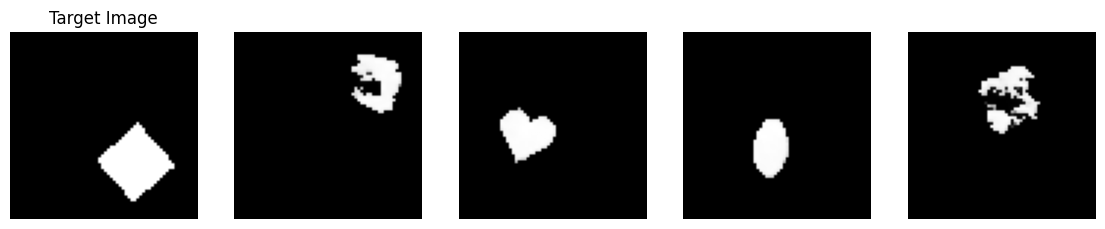

In [39]:
# figure
from utils.base_utils import *

target_img = t2n(images[0])
target_img = np.transpose(target_img, (1,2,0))
target_img = to_01(target_img)
print(target_img.shape)

gen_img_np = t2n(gen_img)
gen_img_np = np.transpose(gen_img_np, (0,2,3,1))
gen_img_np = to_01(gen_img_np)
print(gen_img_np.shape)
print(gen_img_np.min(), gen_img_np.max())


fig, ax = plt.subplots(1,5, figsize=(14,5))
ax[0].imshow(target_img, vmin=0, vmax=1, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Target Image')
for i in range(1,5):
    ax[i].imshow(gen_img_np[i-1], vmin=0, vmax=1, cmap='gray')
    ax[i].axis('off')
    # ax[i].set_title('Generated Image')
plt.show()
# ax[1].axis('off')
# ax[1].set_title('Generated Image')

# ddpm test

In [3]:
from c_training.configs.ddpm_config import DDPM_dSprites_Training_Config
from utils.wandb_utils import get_wandb_run_name, get_artifact
from utils.training import get_checkpoint_dir
from c_training.ddpm_lightning import DDPM_Lightning

project_name = "ddpm_dsprites"
model_num = 2
# artifact_id = "v5" 
artifact_id = "v29" 

# construct config from wandb run
model_path, artifact, config, run_config = get_artifact(model_num=model_num, project_name=project_name)
config = DDPM_dSprites_Training_Config.from_dict(run_config)

# ### really what I want is to find only the name of the checkpoint_dir where the checkpoints are

# # or load from checkpoint
# pretrained_checkpoint_dir = get_checkpoint_dir(model_num=model_num, 
#                                                 project_name=project_name, 
#                                                 checkpoint_dir=config.model_checkpoint_dir, 
#                                                 epoch=None)
# model = DDPM_Lightning.load_from_checkpoint(pretrained_checkpoint_dir)



/mnt/home/blyo1/venvs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


wandb run name: 3ujwbzvu


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact model-3ujwbzvu:latest, 468.43MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.9


In [4]:
# do conditional generation as a sanity check that the model has learned a good representation
from utils.model_init import init_ddpm_model
ddpm = init_ddpm_model(config)

from c_training.ddpm_lightning import DDPM_Lightning
ddpm_lightning = DDPM_Lightning.load_from_checkpoint(model_path, config=config).model

from b_models.ddpm.ddpm_inference import DDPM_Inference
ddpm_inference = DDPM_Inference(ddpm_lightning, config).to(device)

In [5]:
num_samples = 4
ddpm_inference.unconditional_sample_denoiser_only(num_samples)
img = ddpm_inference.x_t
print(img.shape)

torch.Size([4, 1, 64, 64])


(4, 1, 64, 64)
(4, 64, 64, 1)
-0.014307618 1.0154936


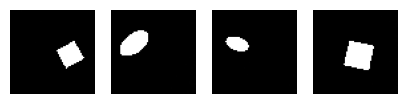

In [12]:
# figure
from utils.base_utils import *
img = t2n(ddpm_inference.x_t)
print(img.shape)
img = np.transpose(img, (0,2,3,1))
img = to_01(img)
print(img.shape)
print(img.min(), img.max())

fig, ax = plt.subplots(1,4, figsize=(5,5))
for i in range(4):
    ax[i].imshow(img[i], vmin=0, vmax=1, cmap='gray')
    ax[i].axis('off')